In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
import os
import numpy as np
import pandas as pd
from copy import deepcopy
from typing import List, Tuple, Dict, Callable
import seaborn as sns
import requests
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial.distance import euclidean
from itertools import permutations, combinations
from joblib import load
import importlib

#from numba import jit, cuda

import tensorflow as tf

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml

from sklearn.pipeline import Pipeline

# os.chdir('C:/Users/imke.bloemen/OneDrive - Accenture/1. Graduation/Code/NewCode/VAE_DBS/src')
# print(os.getcwd())

import VAE_DBS

from VAE_DBS.models.dice_gradients import DiceCounterfactual
from VAE_DBS.utils.utils import *
from VAE_DBS.data.load_data import *
from VAE_DBS.models.DiCE.dice_ml.utils.helpers import DataTransfomer
import random
import VAE_DBS.visualization.create_map_embedding as create_map_embedding
import VAE_DBS.visualization.create_map.create_map_UMAP_test_no_intermediate as create_map_UMAP_test_no_intermediate
# import ssnp_main.code.ssnp as ssnp
import VAE_DBS.models.transformers.ssnp

import skdim
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2


Num GPUs Available:  1


c:\Users\imke.bloemen\AppData\Local\anaconda3\envs\jan-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Original data shape: (70000, 28, 28)
Labels shape: (70000,)
Original number of features: 784
Reduced number of features: 50
Reduced data saved to ../../../data/raw/reduced_fmnist_data.csv


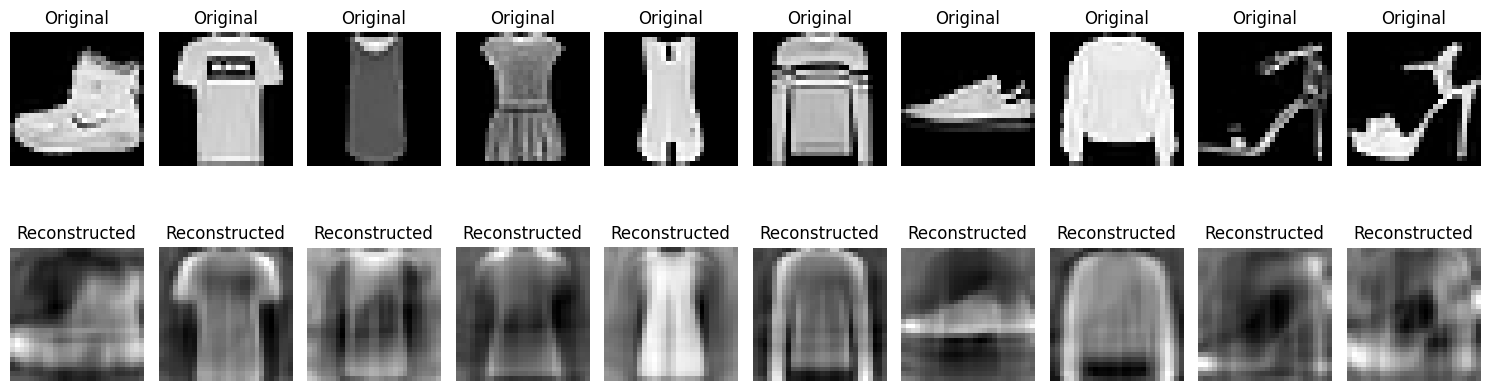

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: Load the Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Combine train and test datasets
X = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Print dataset shapes
print("Original data shape:", X.shape)
print("Labels shape:", y.shape)

# Flatten images to 2D array (samples, features)
X_flat = X.reshape(X.shape[0], -1)  # Flatten each image (28x28) to a vector of size 784

# Step 2: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# Step 3: Perform PCA to retain 80% variance
pca = PCA(n_components=0.8)  # Retain 80% of variance
X_pca = pca.fit_transform(X_scaled)

print(f"Original number of features: {X_flat.shape[1]}")
print(f"Reduced number of features: {X_pca.shape[1]}")

data_with_labels = np.column_stack((X_pca, y))  # Combine PCA data and labels

# Create a DataFrame
columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]  # Column names for PCA components
columns.append('label')  # Add the class label column
reduced_data_df = pd.DataFrame(data_with_labels, columns=columns)

# Save to CSV
output_file = "../../../data/raw/reduced_fmnist_data.csv"
reduced_data_df.to_csv(output_file, index=False)
print(f"Reduced data saved to {output_file}")

# Step 4: Reconstruct images from PCA-reduced data
X_reconstructed = pca.inverse_transform(X_pca)

# Reshape the reconstructed data back to image dimensions (28x28)
X_reconstructed_images = X_reconstructed.reshape(-1, 28, 28)

# Step 5: Plot original and reconstructed images
def plot_original_vs_reconstructed(original, reconstructed, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i], cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i], cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Select a subset of images to display (e.g., the first 10 images)
num_images_to_plot = 10
original_images = X[:num_images_to_plot]
reconstructed_images = X_reconstructed_images[:num_images_to_plot]

# Plot original vs. reconstructed
plot_original_vs_reconstructed(original_images, reconstructed_images)


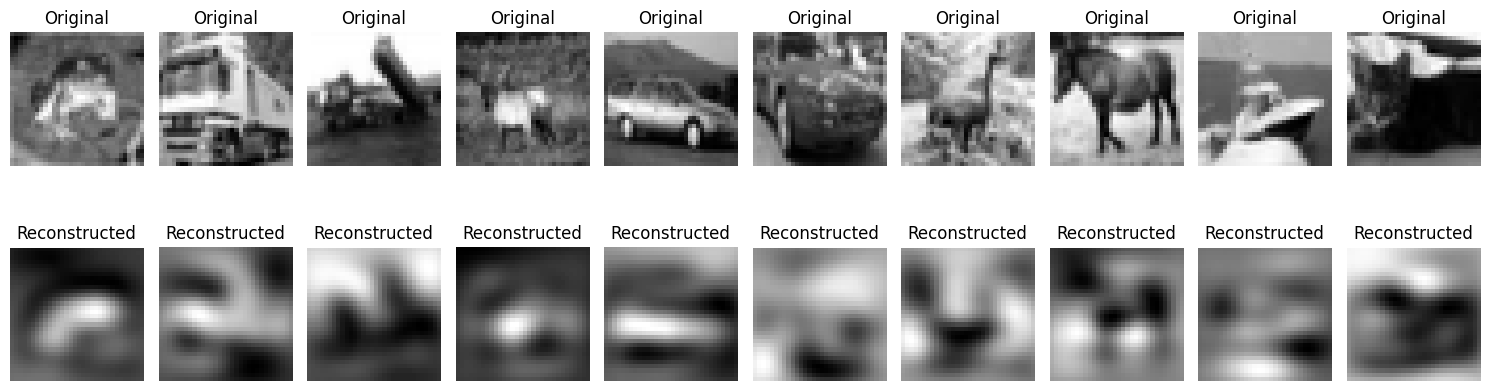

In [8]:
# Reconstruct images from the PCA-reduced data
X_reconstructed = pca.inverse_transform(X_pca)

# Reshape the reconstructed data back to image dimensions (grayscale: 32x32)
X_reconstructed_images = X_reconstructed.reshape(-1, 32, 32)

# Plot original and reconstructed images side by side
def plot_original_vs_reconstructed(original, reconstructed, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i], cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i], cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Select a subset of images to display (e.g., the first 10 images)
num_images_to_plot = 10
original_images = X_gray[:num_images_to_plot].squeeze()  # Original grayscale images
reconstructed_images = X_reconstructed_images[:num_images_to_plot]

# Plot original vs. reconstructed
plot_original_vs_reconstructed(original_images, reconstructed_images)


In [ ]:
def save_mnist_to_csv(output_dir):
    """
    Load the MNIST dataset, combine training and testing data, 
    and save as CSV files.

    Args:
        output_dir (str): Directory where the CSV files will be saved.
    """
    # Load MNIST dataset from TensorFlow/Keras
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    
    # Combine training and testing data
    X = np.concatenate((X_train, X_test), axis=0)
    y = np.concatenate((y_train, y_test), axis=0)
    
    # Flatten the 28x28 images into 1D vectors (for CSV storage)
    X_flattened = X.reshape(X.shape[0], -1)
    
    # Create pandas DataFrame for the features and labels
    X_df = pd.DataFrame(X_flattened, columns=[f'pixel_{i}' for i in range(X_flattened.shape[1])])
    y_df = pd.DataFrame(y, columns=['label'])
    
    # Combine features and labels into one DataFrame
    mnist_df = pd.concat([X_df, y_df], axis=1)
    
    # Save as CSV
    X_csv_path = f"{output_dir}/mnist_features.csv"
    y_csv_path = f"{output_dir}/mnist_labels.csv"
    combined_csv_path = f"{output_dir}/mnist_combined.csv"
    
    # Save separate features and labels
    X_df.to_csv(X_csv_path, index=False)
    y_df.to_csv(y_csv_path, index=False)
    
    # Save combined DataFrame
    mnist_df.to_csv(combined_csv_path, index=False)
    
    print(f"MNIST features saved to: {X_csv_path}")
    print(f"MNIST labels saved to: {y_csv_path}")
    print(f"MNIST combined data saved to: {combined_csv_path}")

#     # Specify output directory
# output_dir = "./data"

# os.makedirs(output_dir, exist_ok=True)

# # Save the MNIST data
# save_mnist_to_csv(output_dir)

In [4]:
total_cfs = 1
# num_iterations = 2
# uncertain_points = [9, 18, 22, 28, 71]
# num_samples = len(uncertain_points)*num_iterations
# samples = uncertain_points*num_iterations
num_samples = 10
dice_cf = DiceCounterfactual(dataset_name='reduced_mnist_data', model_name='mnist_lr', outcome_name='label', preprocessing=None, backend='TF2', model_format='h5', multi_class=True, comparison=True)

Comparison data loaded
Normal data loaded
True
Epoch 1/50
18/18 [==============================] - 2s 15ms/step - loss: 0.3272 - val_loss: 0.0915
Epoch 2/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0389 - val_loss: 0.0172
Epoch 3/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0137 - val_loss: 0.0091
Epoch 4/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 0.0078
Epoch 5/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0083 - val_loss: 0.0073
Epoch 6/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0077 - val_loss: 0.0067
Epoch 7/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0073 - val_loss: 0.0064
Epoch 8/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0069 - val_loss: 0.0061
Epoch 9/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 10/50
18/18 [==============================] - 0s 5ms/step - los

157/157 [==============================] - 0s 1ms/step
Mean Reconstruction MSE: 0.0013369066873565316
Mean Reconstruction MAE: 0.017037175595760345


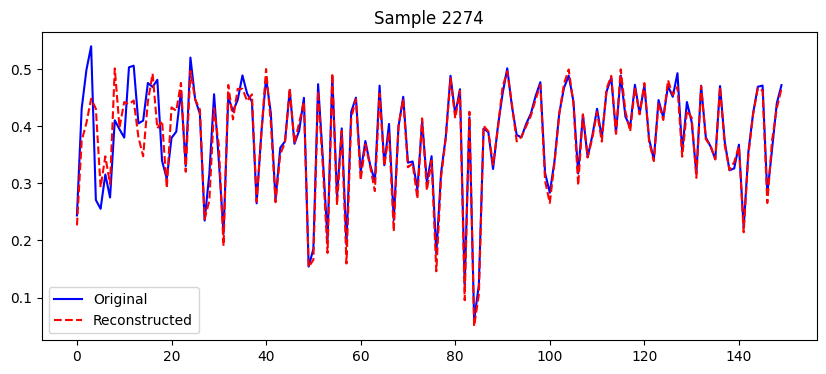

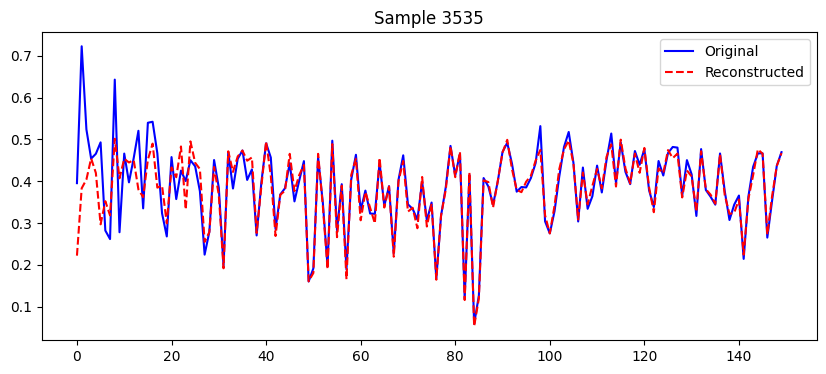

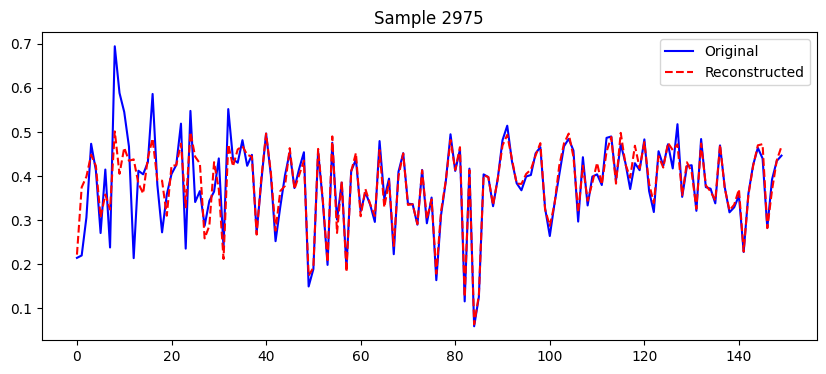

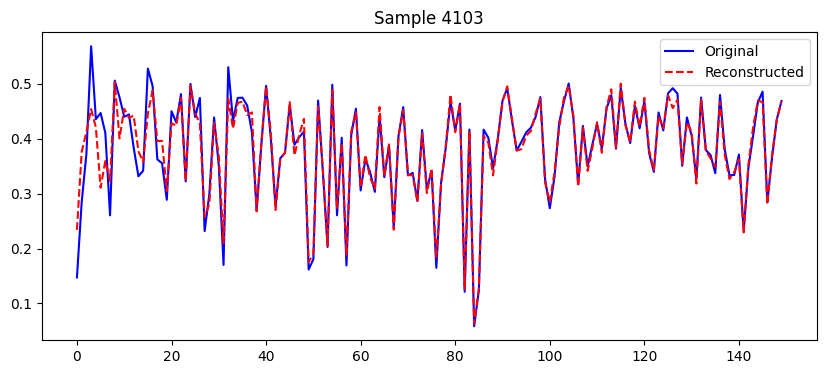

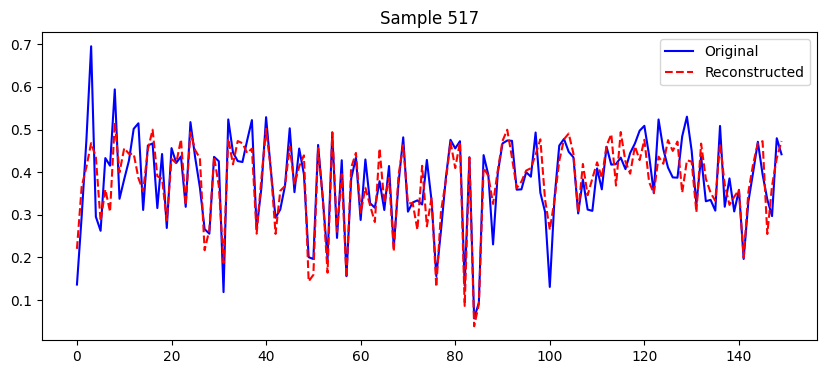

157/157 [==============================] - 0s 916us/step


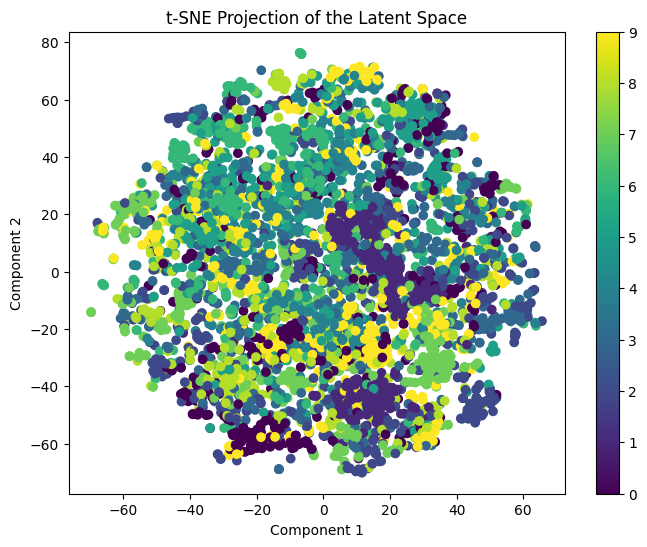

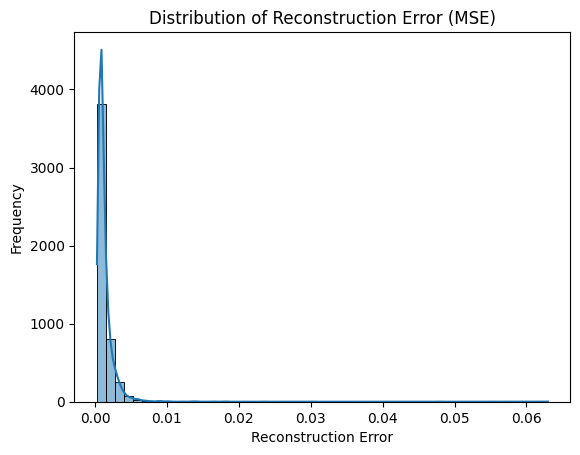

Correlation between original and reconstructed features:
PC1      0.002822
PC2     -0.011097
PC3     -0.015062
PC4      0.011870
PC5     -0.004859
           ...   
PC146    0.004807
PC147    0.004160
PC148   -0.006718
PC149    0.026577
PC150   -0.006960
Length: 150, dtype: float64


In [32]:
dice_cf.evaluate_autoencoder()

In [5]:
counterfactuals, dataset, predictions_dataset, intermediate_y_pred, dice_data, cf_points_binary, sampled_indices, sampled_predictions, intermediate_points, instance_interest_idxs, counterfactual_idxs, all_gradients, gradient_instance_interest_idxs, gradient_counterfactual_idxs, iterations, class_paths = dice_cf.fit_transform_all_gradient(num_samples=num_samples, total_cfs=total_cfs, desired_class='opposite', prediction_weight=0.5, ae_weight=0.5, proto_weight=0.7, samples=None, learning_rate=0.01)

157/157 [==============================] - 0s 927us/step
Sampled indices: [4145 1279 3989 3667  368  660 4335 1580 4769 2203]
Processing #0 instance 4145... with prediction [6.7516142e-01 1.5837562e-04 8.2711922e-03 2.8032260e-02 6.4205928e-03
 1.8944198e-01 1.3494606e-02 4.5814570e-03 2.8483033e-02 4.5955040e-02]
Generating counterfactuals for current class 0 and target class 1...
Generation of counterfactuals started...
Initial prediction for query instance: [0.17367715 0.08842854 0.08914887 0.09092807 0.08898405 0.10685559
 0.08961575 0.08882054 0.09096906 0.09257244]
Target class defined: 1
step 1,  loss=1.2138
Iteration -1: CF probabilities = [array([0.1405091 , 0.08940857, 0.09041324, 0.09433252, 0.09033249,
       0.12486789, 0.09111205, 0.08988416, 0.09362388, 0.09551606],
      dtype=float32)]
step 51,  loss=0.740257
Diverse Counterfactuals found! total time taken: 00 min 01 sec
Generation of counterfactuals completed.
Counterfactuals generated for class 1:        PC1       PC

In [41]:
dice_cf.save_data(version='comparison_data_mnist_10')

Original data saved to ../../../output_data/sampled_data\reduced_mnist_data_original_comparison_data_mnist_10.csv
Counterfactuals saved to ../../../output_data/sampled_data\reduced_mnist_data_counterfactuals_comparison_data_mnist_10.csv
Intermediate gradient points saved to ../../../output_data/sampled_data\reduced_mnist_data_intermediate_gradients_comparison_data_mnist_10.csv


In [7]:
_, model_for_predictions = load_model_dice('TF2', 'mnist_lr')

True


In [8]:
predictions_dataset_output = [np.argmax(x) for x in predictions_dataset]
intermediate_y_pred_output = [np.argmax(x) for x in intermediate_y_pred]
pred_map = create_map_embedding.PredictionMap(grid_size=300, original_data=dataset, intermediate_gradient_points=intermediate_points, counterfactuals=counterfactuals, all_gradients=all_gradients, number_of_neighbors=4, model_for_predictions=model_for_predictions, scaler_path_2D='../models/transformers/scalers/minmax_scaler_mnist.save', projection_method='ssnp', projection_name='mnist_ssnp', intermediate_predictions=np.array(intermediate_y_pred_output), original_predictions=np.array(predictions_dataset_output), counterfactual_predictions=np.array(cf_points_binary), outcome_name='label', n_classes=10, version='mnist_1.8', comparison=True)

Before stacking:
intermediate_gradient_points shape: (4636, 150)
counterfactuals shape: (89, 150)
intermediate_predictions shape: (4636,)
counterfactual_predictions shape: (89,)
After stacking:
intermediate_gradient_points shape: (4725, 150)
intermediate_predictions shape: (4725, 1)


In [9]:
pred_map.fit_points_2D()

157/157 [==============================] - 0s 1ms/step
Original data projected to 2D.
145/145 [==============================] - 0s 1ms/step
Grid created.
Plot saved as 'ssnp_plot_with_grid_mnist_1.8.png'.
Plot saved as 'original_data_points_mnist_1.8.png'.


Constructing KDTree in SSNP space with combined data...
KDTree constructed.
4/4 [==============================] - 0s 2ms/step
Processed 0 / 90000 grid points.
4/4 [==============================] - 0s 0s/step
Processed 1000 / 90000 grid points.
4/4 [==============================] - 0s 4ms/step
Processed 2000 / 90000 grid points.
4/4 [==============================] - 0s 0s/step
Processed 3000 / 90000 grid points.
4/4 [==============================] - 0s 4ms/step
Processed 4000 / 90000 grid points.
4/4 [==============================] - 0s 5ms/step
Processed 5000 / 90000 grid points.
4/4 [==============================] - 0s 0s/step
Processed 6000 / 90000 grid points.
4/4 [==============================] - 0s 672us/step
Processed 7000 / 90000 grid points.
4/4 [==============================] - 0s 658us/step
Processed 8000 / 90000 grid points.
4/4 [==============================] - 0s 4ms/step
Processed 9000 / 90000 grid points.
4/4 [==============================] - 0s 4ms/step
Proce

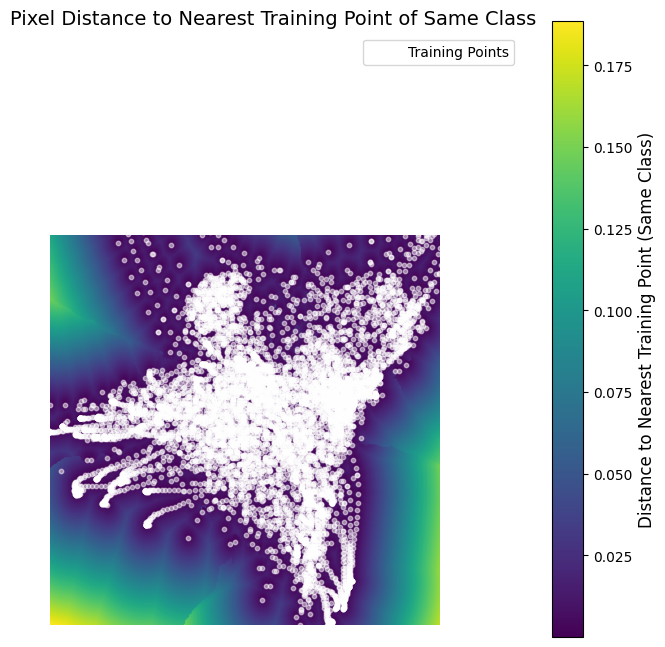

Prediction grid image saved as 'prediction_grid_image_mnist_1.8.png'.
Prediction grid image with data points saved as 'prediction_grid_with_data_points_mnist_1.8.png'.
Prediction grid image with data points saved as 'prediction_grid_with_data_points_mnist_1.8.png'.
Confidence map image saved to ../../../results/images/confidence_images/confidence_image_multilateration_mnist_1.8.png
Alpha-blended prediction grid image saved as '../../../results/images/mapping_images/prediction_grid_image_alpha_mnist_1.8.png'.
Estimated high-dimensional points saved as 'estimated_hd_points_mnist_1.8.csv'.


In [10]:
pred_map.fit_grid_multilateration(version='mnist_1.8')

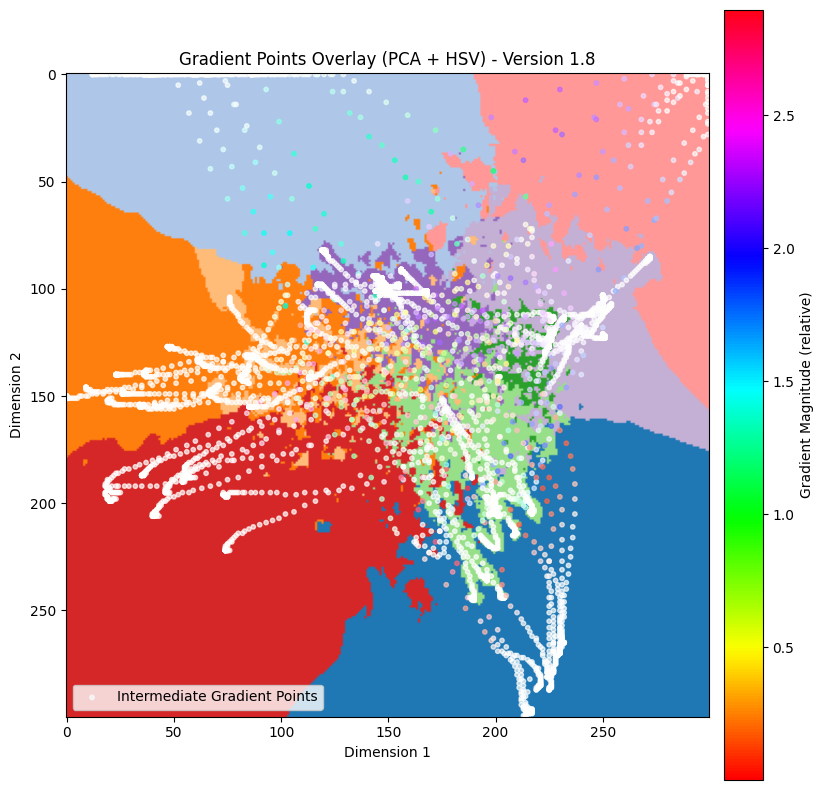

Gradient points overlay image saved as '../../../results/images/gradient_plots/gradient_points_overlay_1.8.png'.


In [15]:
pred_map.plot_gradient(version='1.8')

2/2 [==============================] - 0s 0s/step


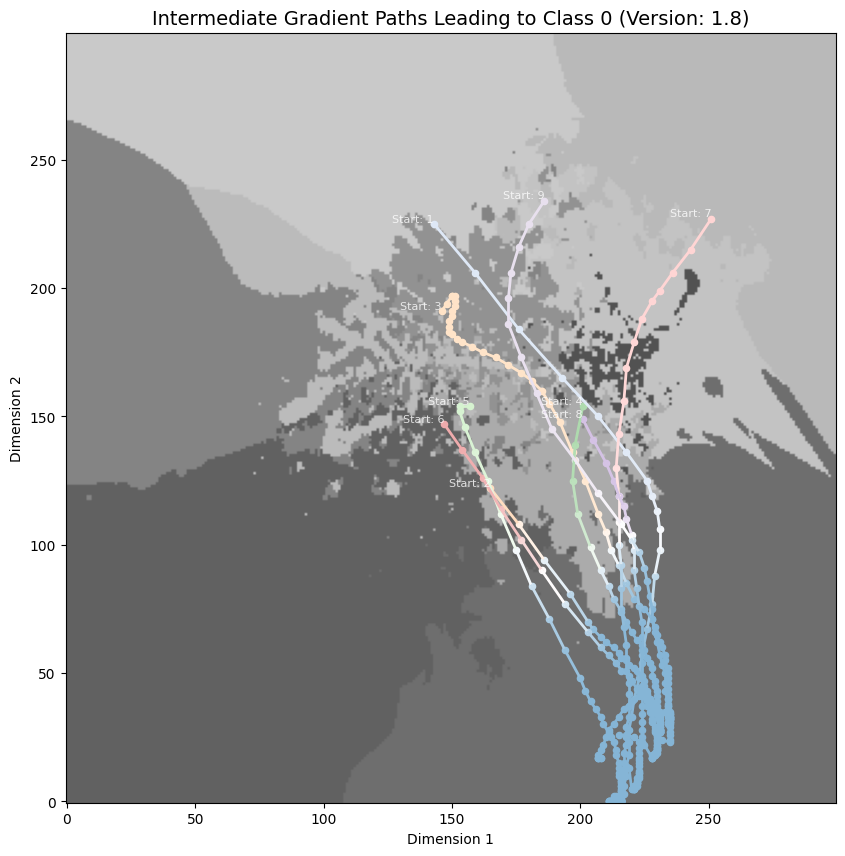

Class 0 paths overlay image saved as '../../../results/images/gradient_plots/class_0_paths_overlay_1.8.png'.
2/2 [==============================] - 0s 16ms/step


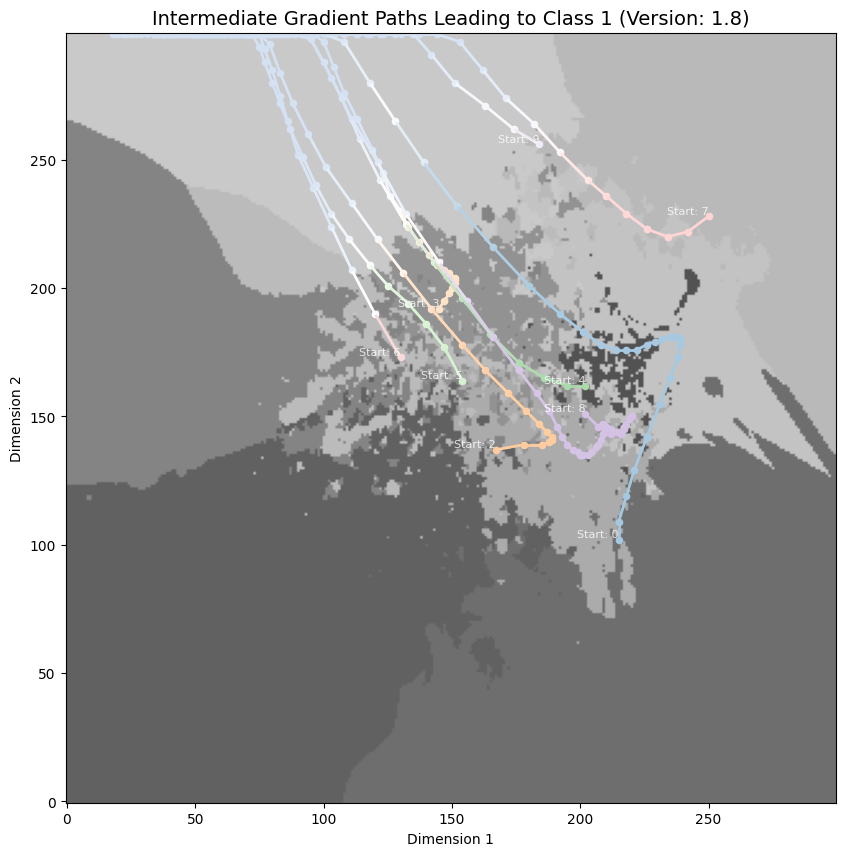

Class 1 paths overlay image saved as '../../../results/images/gradient_plots/class_1_paths_overlay_1.8.png'.
2/2 [==============================] - 0s 0s/step


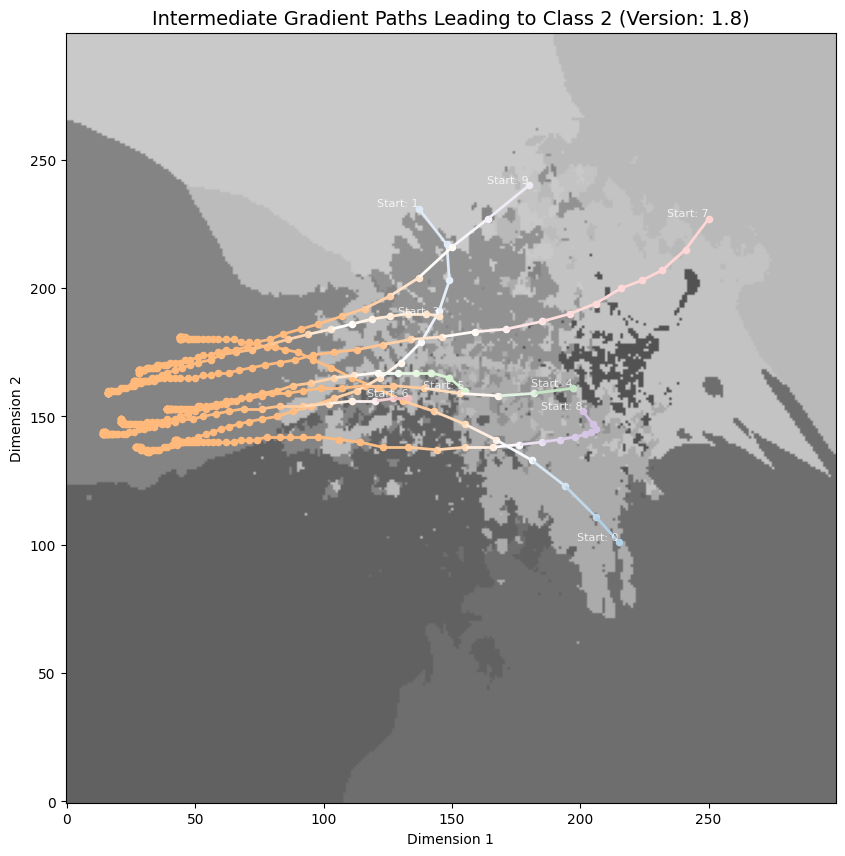

Class 2 paths overlay image saved as '../../../results/images/gradient_plots/class_2_paths_overlay_1.8.png'.
2/2 [==============================] - 0s 0s/step


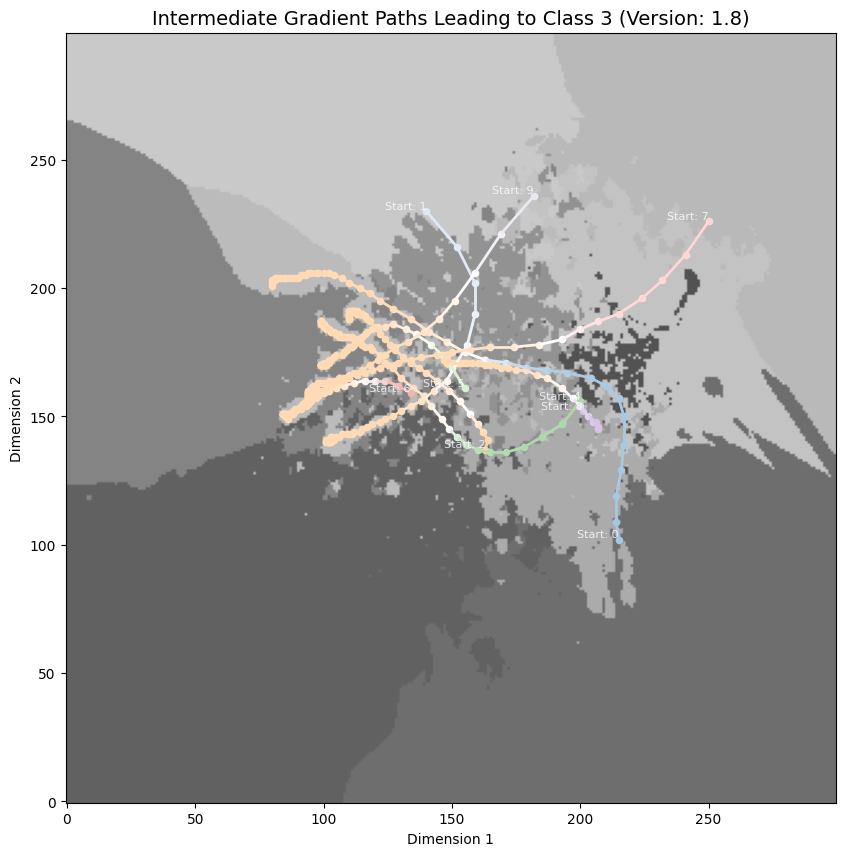

Class 3 paths overlay image saved as '../../../results/images/gradient_plots/class_3_paths_overlay_1.8.png'.
2/2 [==============================] - 0s 3ms/step


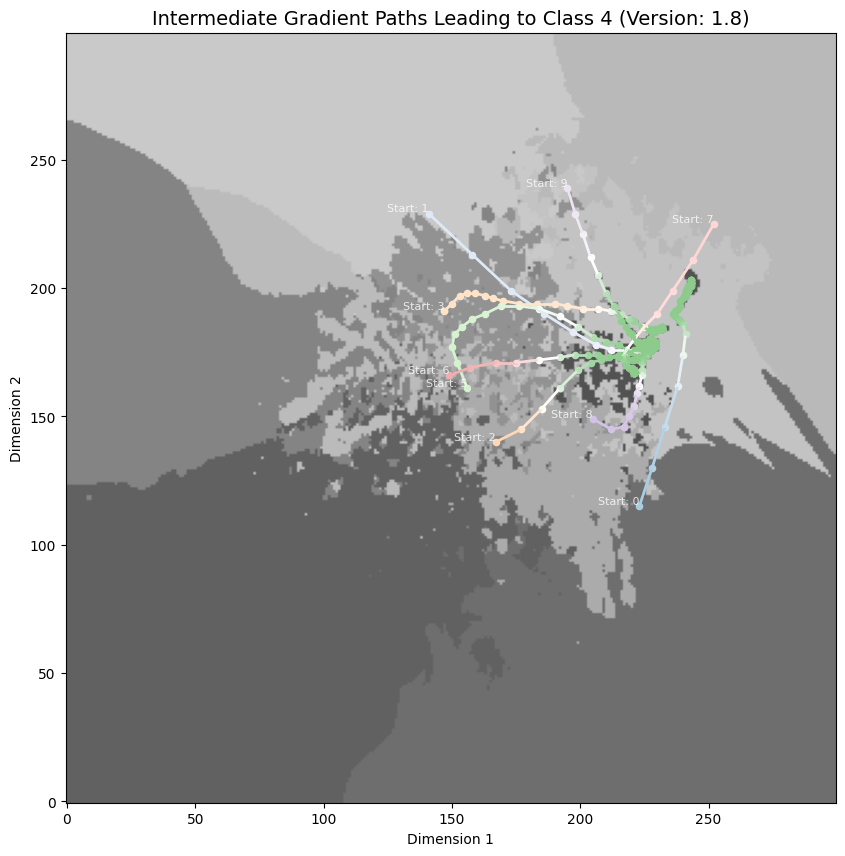

Class 4 paths overlay image saved as '../../../results/images/gradient_plots/class_4_paths_overlay_1.8.png'.
2/2 [==============================] - 0s 0s/step


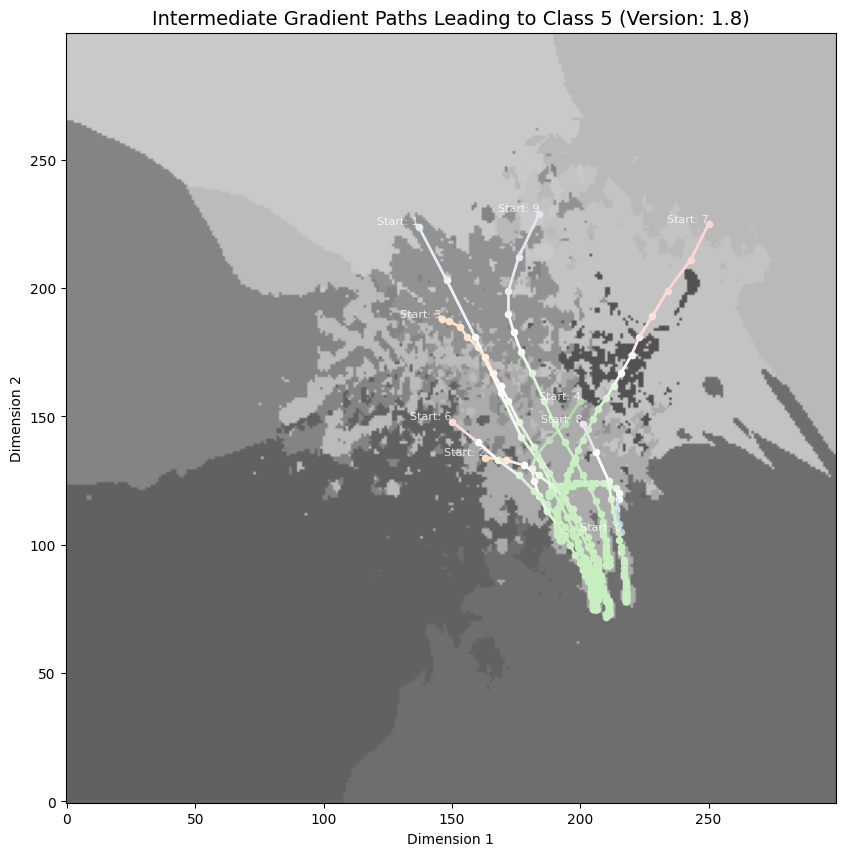

Class 5 paths overlay image saved as '../../../results/images/gradient_plots/class_5_paths_overlay_1.8.png'.
2/2 [==============================] - 0s 0s/step


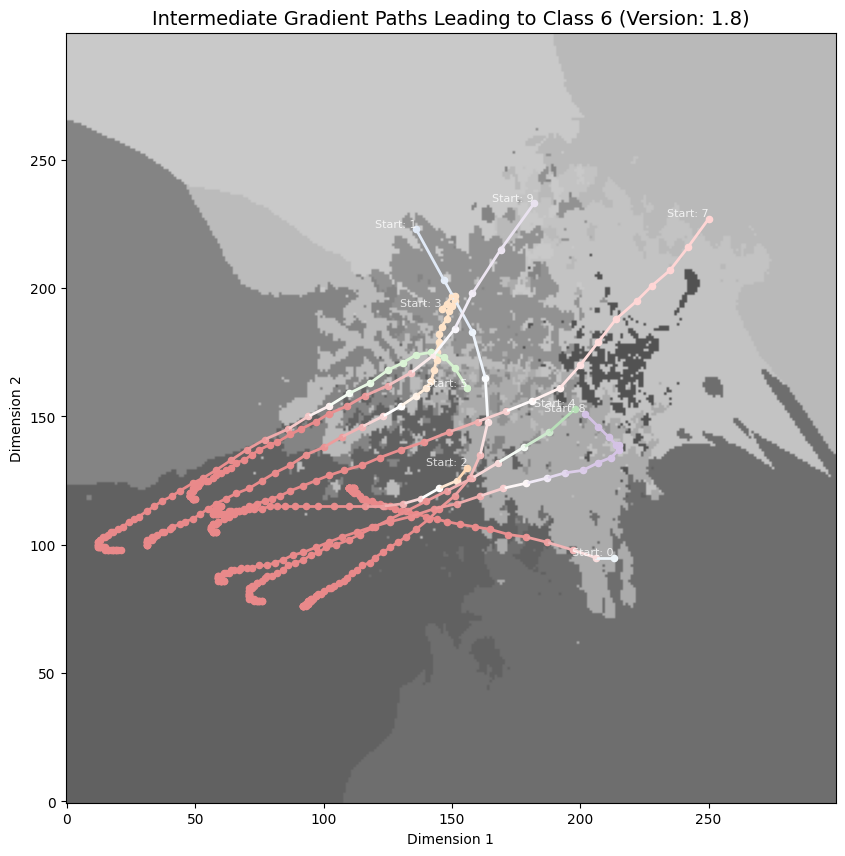

Class 6 paths overlay image saved as '../../../results/images/gradient_plots/class_6_paths_overlay_1.8.png'.
2/2 [==============================] - 0s 0s/step


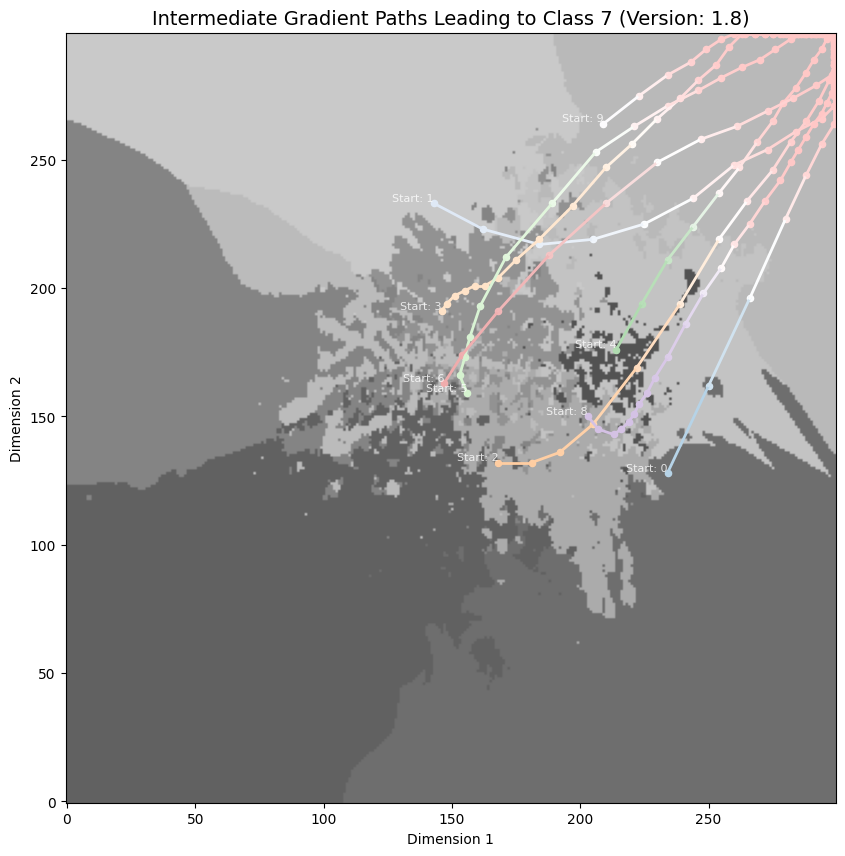

Class 7 paths overlay image saved as '../../../results/images/gradient_plots/class_7_paths_overlay_1.8.png'.
2/2 [==============================] - 0s 0s/step


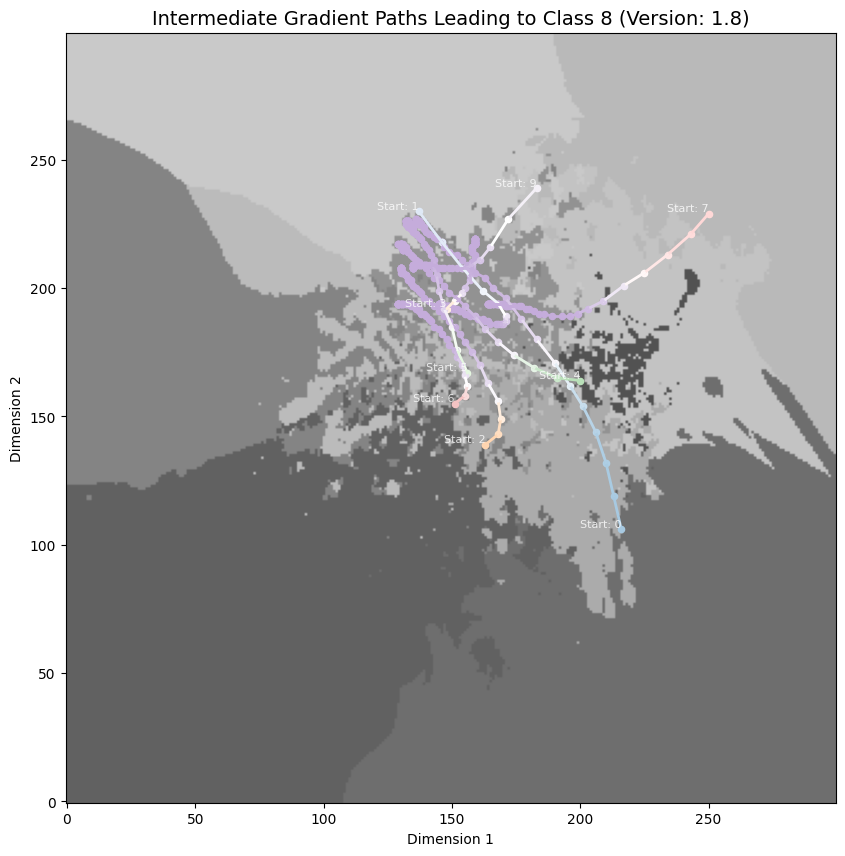

Class 8 paths overlay image saved as '../../../results/images/gradient_plots/class_8_paths_overlay_1.8.png'.
2/2 [==============================] - 0s 0s/step


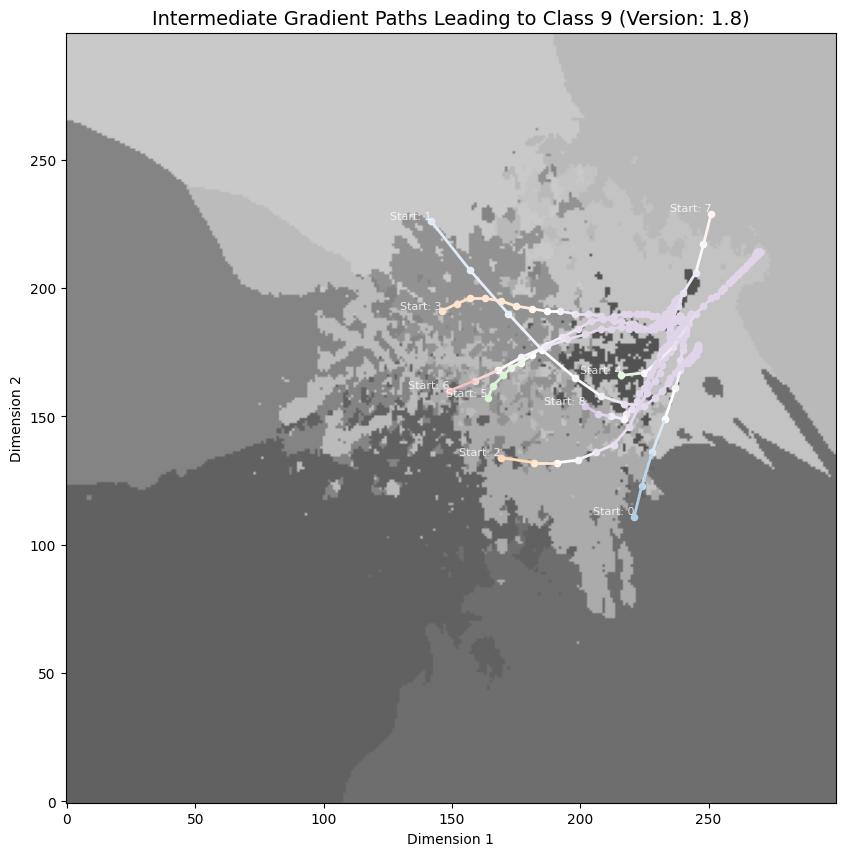

Class 9 paths overlay image saved as '../../../results/images/gradient_plots/class_9_paths_overlay_1.8.png'.


In [246]:
for i in range(10):
    pred_map.plot_class_paths(version='1.8', target_class=i, paths_dict=class_paths)

Randomly selected features: ['125', '90', '79', '19', '126', '30', '77', '93', '68', '80']
Scatterplot matrix saved to scatterplots


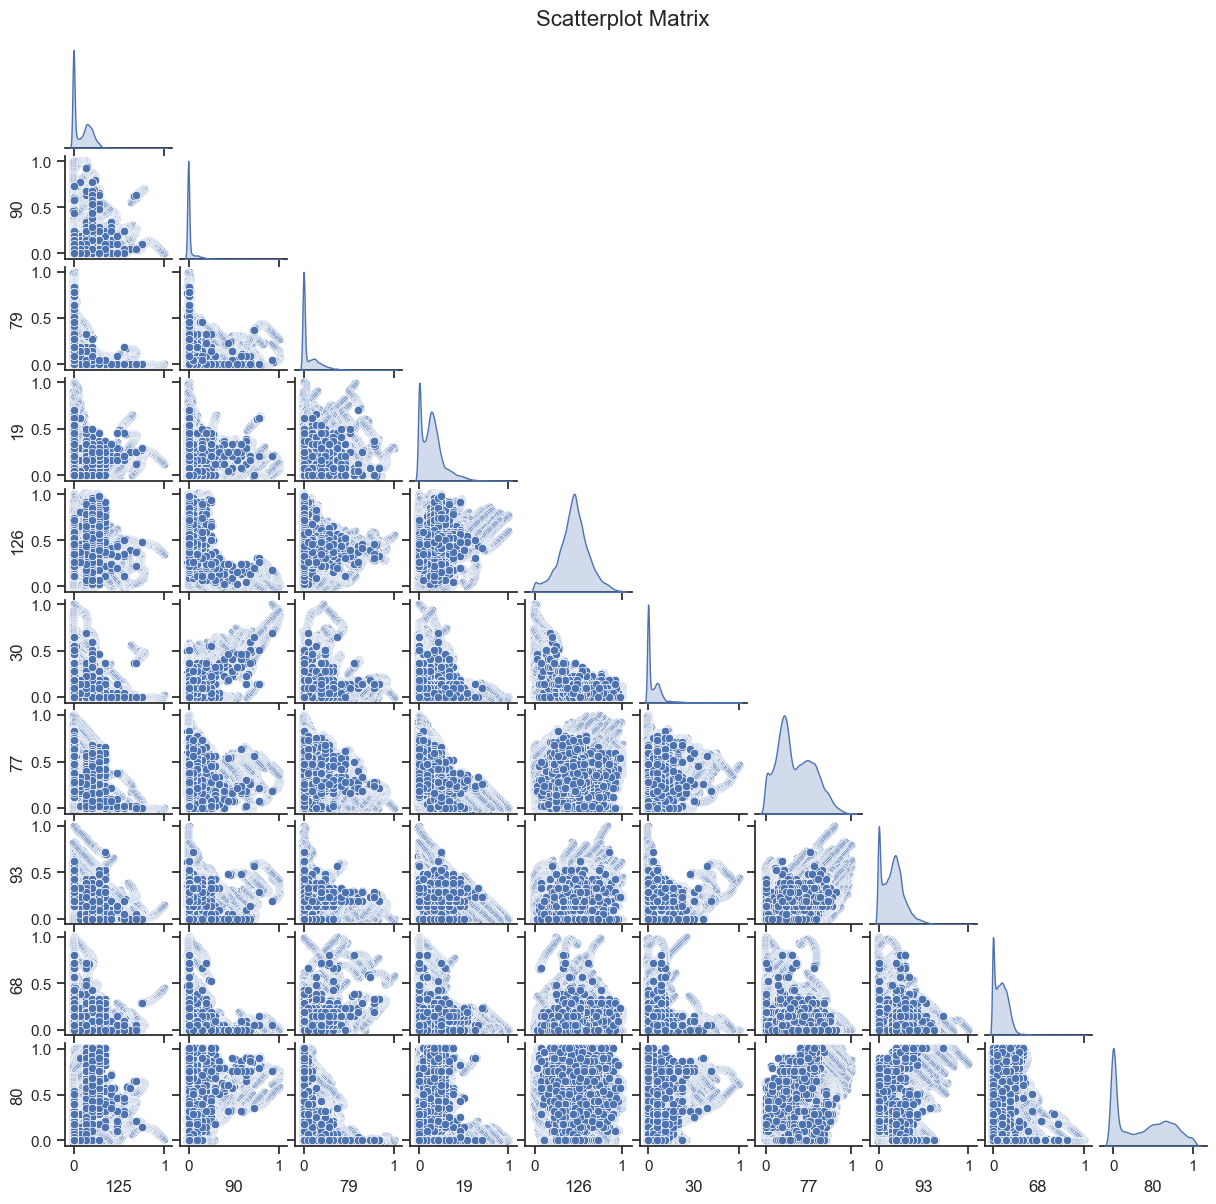

In [37]:
#Scatterplots

from plots import *

#Scatterplot for generated high-dimensional data
high_dim_intermediate = pd.read_csv('output/fmnist_test_features_restricted_intermediate_gradients.csv')
high_dim_intermediate['label'] = intermediate_y_pred_binary
high_dim_original = pd.read_csv('output/fmnist_test_features_restricted_original.csv')
high_dim_original['label'] = predictions_dataset_binary
high_dim_counterfactuals = pd.read_csv('output/fmnist_test_features_restricted_counterfactuals.csv')
high_dim_counterfactuals['label'] = cf_points_binary
combined_high_dim_data = pd.concat([high_dim_original, high_dim_intermediate, high_dim_counterfactuals], axis=0)
combined_high_dim_data = combined_high_dim_data.reset_index(drop=True)
scatterplot_matrix(combined_high_dim_data, features=None, hue=None, save_path='scatterplots', figsize=(12, 12), random_subset_size=10)

In [96]:
X = all_gradients.values

X_centered = X - X.mean(axis=0, keepdims=True)

# Compute SVD
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

# V is the transpose of Vt
V = Vt.T  # shape (d, d)

# Extract first two principal components
PC1 = V[:, 0]  # first principal component
PC2 = V[:, 1]  # second principal component

# Project data onto the first two principal components
T = X_centered @ V[:, :2]  # shape (n, 2)

In [101]:
def gradient_to_hsv(gX, gY):
    """
    Convert a gradient field represented by gX, gY into HSV colors.
    Hue corresponds to the direction (angle) of the gradient,
    Saturation corresponds to the magnitude (normalized),
    Value is fixed to 1.0.
    """
    angle = np.arctan2(gY, gX)
    # Normalize angle to [0,1]
    H = (angle + np.pi) / (2 * np.pi)
    # Compute magnitude and normalize
    magnitude = np.sqrt(gX**2 + gY**2)
    mag_max = magnitude.max() if magnitude.max() != 0 else 1
    S = magnitude / mag_max
    V = np.ones_like(H)
    hsv = np.stack((H, S, V), axis=-1)
    return hsv

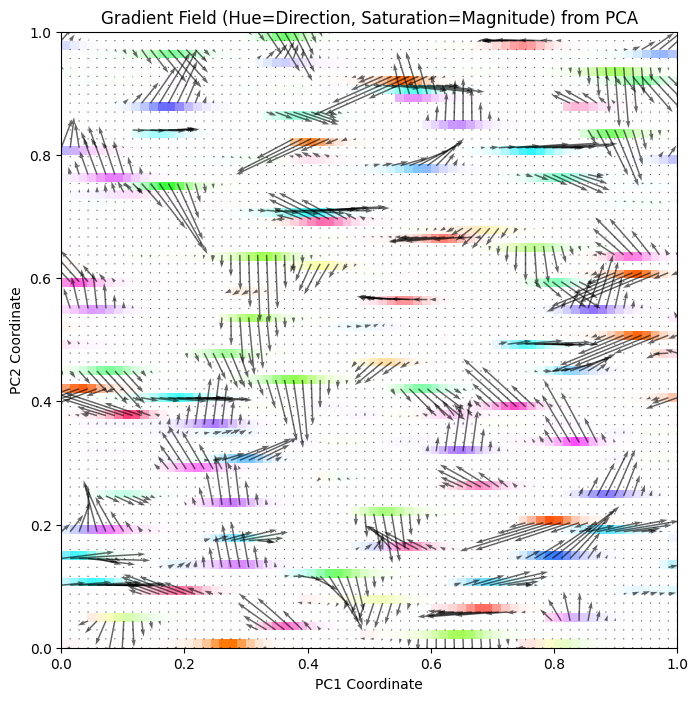

In [104]:
gX = T[:,0]
gY = T[:,1]

num_points = gX.shape[0]
grid_size = int(np.floor(np.sqrt(num_points)))

grid_count = grid_size**2
gX = gX[:grid_count].reshape(grid_size, grid_size)
gY = gY[:grid_count].reshape(grid_size, grid_size)

# 7. Convert to HSV using the gradient_to_hsv function
hsv = gradient_to_hsv(gX, gY)

# 8. Convert HSV to RGB for plotting
rgb = mcolors.hsv_to_rgb(hsv)

# Create coordinate grids (assuming a normalized coordinate system)
x_coords = np.linspace(0, 1, grid_size)
y_coords = np.linspace(0, 1, grid_size)
X_grid, Y_grid = np.meshgrid(x_coords, y_coords)

# 9. Plot the result
plt.figure(figsize=(8, 8))
plt.imshow(rgb, origin='lower', extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])
plt.title('Gradient Field (Hue=Direction, Saturation=Magnitude) from PCA')
plt.xlabel('PC1 Coordinate')
plt.ylabel('PC2 Coordinate')

# Overlay quiver to show actual vectors
plt.quiver(X_grid, Y_grid, gX, gY, color='black', alpha=0.6)
plt.show()

In [ ]:
all_intermediate_points_gradient = all_intermediate_points_gradient.drop('label', axis=1) if 'label' in all_intermediate_points_gradient.columns else all_intermediate_points_gradient
cf_combined = cf_combined.drop('label', axis=1) if 'label' in cf_combined.columns else cf_combined
pred_map = create_map_UMAP_test_no_intermediate.PredictionMap(300, cf_combined, all_intermediate_points_gradient, 1, model_for_predictions, scaler, intermediate_y_pred, y_test_combined, version='no_intermediate')

In [ ]:
pred_map.fit_points_2D()

In [ ]:
pred_map.fit_grid_multilateration(version='no_intermediate')